In [187]:
import glob2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib import pyplot
from scipy import stats

warnings.filterwarnings("ignore")

In [188]:
# upload all the datasets and making a variable with the name of city
dataframes = []

for file in glob2.glob('Data/*.csv'):
    df = pd.read_csv(file)
    if any(city in file for city in ['London', 'Lonson']):
        df['city'] = np.repeat('London', df.shape[0])
    elif 'Los Angeles' in file:
        df['city'] = np.repeat('Los Angeles', df.shape[0])
    else:
        df['city'] = np.repeat('San Francisco', df.shape[0])
    dataframes.append(df)

In [3]:
# merging all the dfs
data = pd.concat(dataframes, axis=0).reset_index()

In [4]:
data.shape

(244148, 36)

In [5]:
data.head()

,index,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,created_at,updated_at,...,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id,city
0,0,11479007,2018-04-27 7:52:34 am BST,2018-04-27,2018-04-27 07:52:34 UTC,UTC,159021,muki,2018-04-27 07:06:17 UTC,2018-04-27 09:26:56 UTC,...,NaN,False,gps,gps,lesser celandine,Ficaria verna,lesser celandine,Plantae,204321.0,London
1,1,11480212,2018-04-27 8:39:41 am BST,2018-04-27,2018-04-27 07:39:41 UTC,London,664459,lucyrobinsonnhm,2018-04-27 08:02:52 UTC,2019-01-29 21:16:34 UTC,...,open,False,gps,gps,Pigeon biset domestique,Columba livia domestica,Feral Pigeon,Aves,122767.0,London
2,2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27,2018-04-27 06:34:31 UTC,Amsterdam,908315,tess26,2018-04-27 08:42:01 UTC,2018-04-27 11:01:49 UTC,...,NaN,False,NaN,NaN,NaN,Hyacinthoides hispanica,Spanish Bluebell,Plantae,57635.0,London
3,3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27,2018-04-27 07:54:35 UTC,Amsterdam,796473,bryonycross,2018-04-27 08:54:45 UTC,2018-04-27 20:23:41 UTC,...,NaN,False,NaN,NaN,Green Alkanet,Pentaglottis sempervirens,Green Alkanet,Plantae,166466.0,London
4,4,11482247,2018-04-27 8:42:21 am BST,2018-04-27,2018-04-27 07:42:21 UTC,London,664459,lucyrobinsonnhm,2018-04-27 10:09:55 UTC,2018-04-27 15:37:31 UTC,...,NaN,False,gps,gps,London Plane,Platanus × hispanica,London Plane,Plantae,552449.0,London


In [6]:
data.columns

Index(['index', 'id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'created_at', 'updated_at',
       'quality_grade', 'license', 'url', 'image_url', 'sound_url', 'tag_list',
       'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'geoprivacy', 'taxon_geoprivacy',
       'coordinates_obscured', 'positioning_method', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'city'],
      dtype='object')

In [189]:
# making the variable representing days
data['ymd'] = pd.to_datetime(data['time_observed_at']).dt.to_period('D')

In [190]:
# making the variable representing years
data['year'] = pd.DatetimeIndex(data['time_observed_at']).year

In [191]:
# calculating the number of observations for years and cities
data = data[data['year'].isin(['2018', '2019', '2020'])]
days = data.groupby(['city', 'ymd', 'year'])['id'].count().reset_index()

In [192]:
# calculating proportions
days_sum = days.groupby(['city', 'year'])['id'].sum().reset_index()
days_sum.rename(columns={'id': 'total'}, inplace=True)
days_sum = pd.merge(days, days_sum,  how='left', left_on=['city','year'], right_on = ['city','year'])
days_sum['prop'] = np.array(days_sum["id"])/np.array(days_sum['total'])

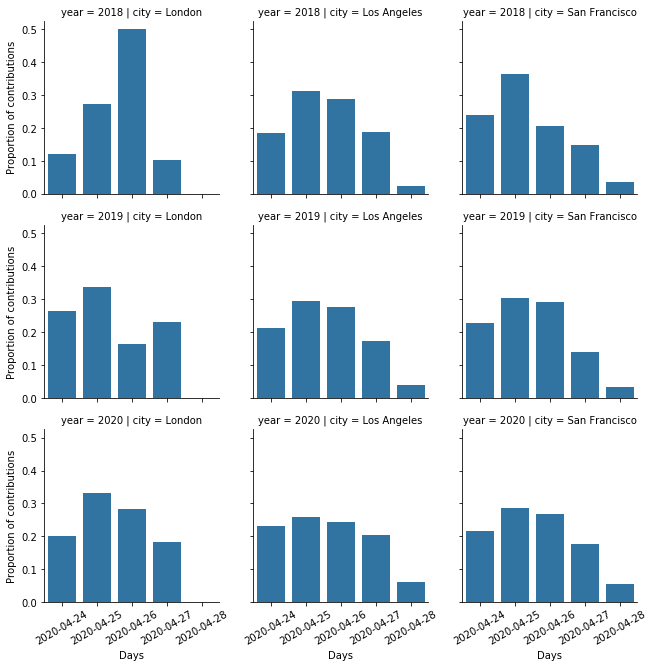

In [193]:
# visualizing proportions
graph = sns.FacetGrid(days_sum, col ='city',row='year') 
graph.map(sns.barplot, "ymd", "prop").add_legend() 
graph.set_xticklabels(rotation=30)

axes = graph.axes.flatten()
for ax in axes[6:9]:
    ax.set_xlabel("Days")
for ax in axes[::3]:
    ax.set_ylabel("Proportion of contributions")

In [195]:
# calculating stats on the activity
stats_cs = data.groupby(['city', 'user_id', 'year'])['id'].count().reset_index()

In [52]:
# function allows to calculate percentiles inside pandas function agg()
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [196]:
stats_cs.groupby(
   ['city', 'year']
).agg(
    {
         'id':[np.mean, np.median, max, percentile(25), percentile(75), np.std]
    }
)

id                                           \
                         mean median   max percentile_25 percentile_75   
city          year                                                       
London        2018  47.853211      9  1701             2            28   
              2019  36.440433      4  3255             1            18   
              2020  14.583483      2   822             1             7   
Los Angeles   2018  45.817045      4  2877             1            15   
              2019  39.590651      4  3171             1            18   
              2020  21.908081      3  1722             1            10   
San Francisco 2018  51.543023      5  2643             2            21   
              2019  39.004730      5  2190             1            18   
              2020  23.261650      2  1551             1             8   

                                
                           std  
city          year              
London        2018  170.747476  
              2019  205.479311  
              2020   59.952580  
Los Angeles   2018  209.184580  
              2019  181.708517  
              2020  103.459360  
San Francisco 2018  182.993645  
              2019  153.218878  
              2020  101.384937

In [55]:
perc75 = stats_cs.groupby(['city', 'year']).agg({'id':percentile(75)}).reset_index()
stats_cs = pd.merge(stats_cs, perc75,  how='left', left_on=['city','year'], right_on = ['city','year'])

In [78]:
# making the typology of users: those ones who are located in 75th percentile and higher, those ones who have made
# only one contribution and others
stats_cs['type_user'] = ['75_perc' if x > y else 'one_contribution' if x == 1 else "regular" for x,y in 
                      zip(stats_cs['id_x'],stats_cs['id_y'])]

In [118]:
# calculating activity of types of users for years and cities
users_stats = stats_cs.groupby(['city', 'year', 'type_user'])['user_id'].count().reset_index()

In [124]:
# calculating proportions
users_total = stats_cs.groupby(["city", "year"])["user_id"].count().reset_index()
users_total.rename(columns={'user_id': 'total'}, inplace=True)
users_stats = pd.merge(users_stats, users_total,  how='left', left_on=['city','year'], right_on = ['city','year'])
users_stats['prop'] = np.array(users_stats['user_id'])/np.array(users_stats['total'])

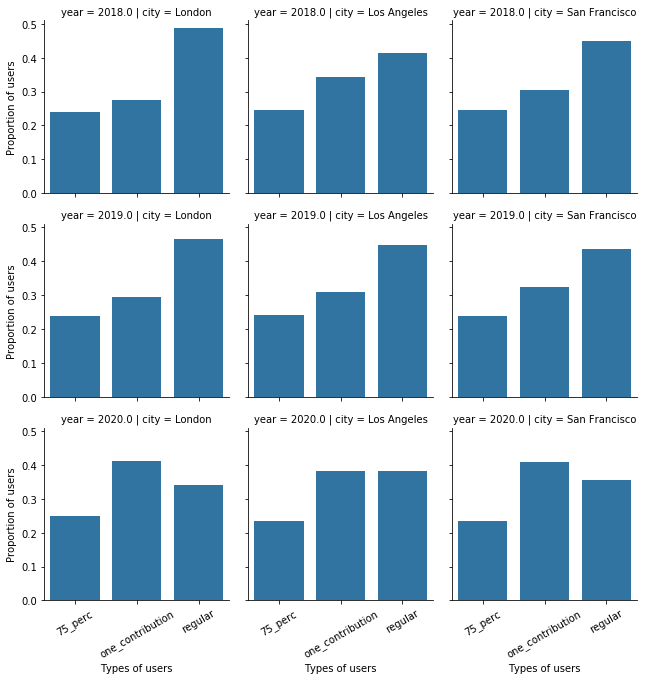

In [129]:
# visualizing the activity of different types of users
graph = sns.FacetGrid(users_stats, col ='city',row='year') 
graph.map(sns.barplot, "type_user", "prop").add_legend() 
graph.set_xticklabels(rotation=30)

axes = graph.axes.flatten()
for ax in axes[6:9]:
    ax.set_xlabel("Types of users")
for ax in axes[::3]:
    ax.set_ylabel("Proportion of users")

In [180]:
# function calculates chi2 squared test and returns a heatmpa with Pearson residuals
def pearson_heatmap(x, y):
    crosst = pd.crosstab(x, y)
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosst)
    one = (crosst.iloc[0,:] - ex[0])/np.sqrt(ex[0])
    two = (crosst.iloc[1,:] - ex[1])/np.sqrt(ex[1])
    three = (crosst.iloc[2,:] - ex[2])/np.sqrt(ex[2])
    four = (crosst.iloc[3,:] - ex[3])/np.sqrt(ex[3])
    return sns.heatmap(pd.concat([one, two, three, four], axis=1), annot=True,
                fmt=".1f",
                annot_kws={'size':10})

In [175]:
data_london = data[(data['city'] == 'London')]

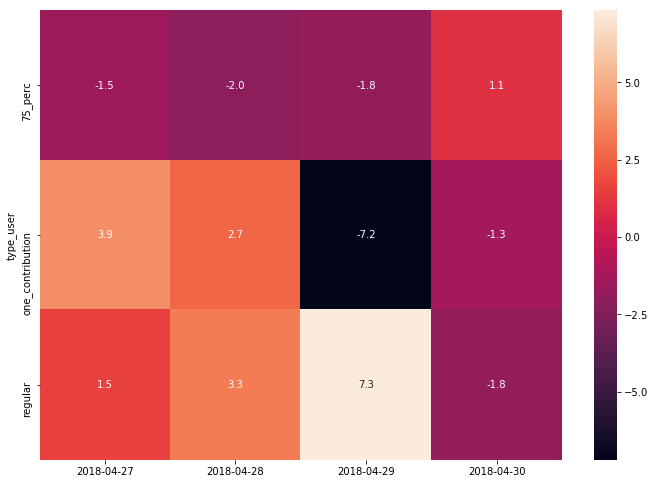

In [182]:
# calculating a heatmap for days and the types of users for London
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(data_london.ymd, data_london.type_user)

In [177]:
data_ls = data[(data['city'] == 'Los Angeles')]

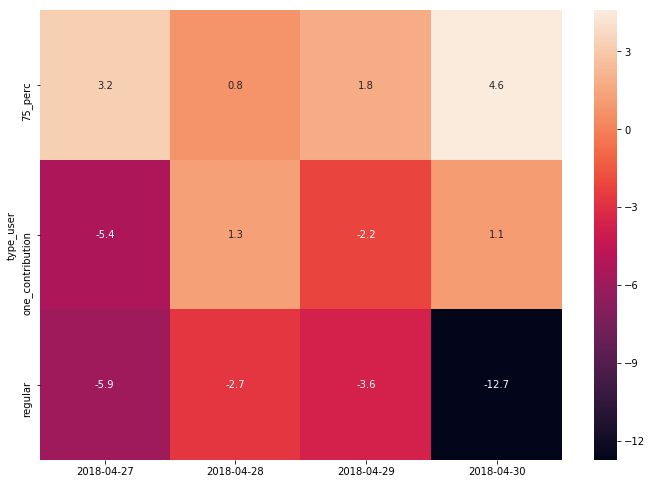

In [181]:
# calculating a heatmap for days and the types of users for Los Angeles
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(data_ls.ymd, data_ls.type_user)

In [197]:
data_sf = data[(data['city'] == 'San Francisco')]

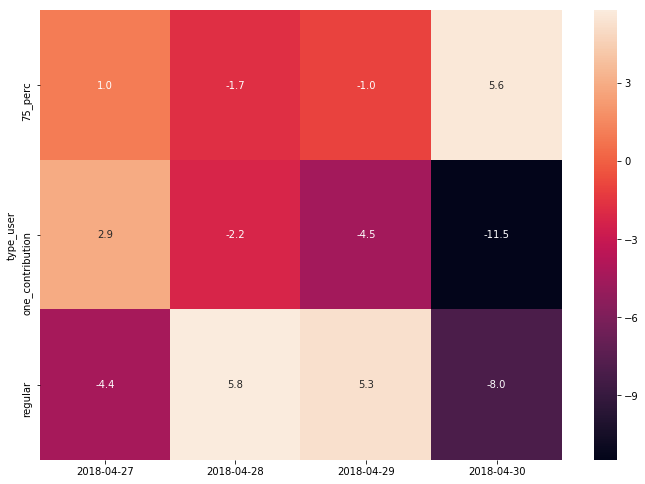

In [198]:
# calculating a heatmap for days and the types of users for Los Angeles
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(data_sf.ymd, data_sf.type_user)

# Mapping

In [136]:
data = pd.merge(data, stats_cs[['user_id','type_user']],  how='left', on='user_id')

In [138]:
london_places = data[(data['city'] == 'London')]

In [139]:
BBox = (london_places.longitude.min(), london_places.longitude.max(),
      london_places.latitude.min(), london_places.latitude.max())

In [155]:
BBox

(-0.5176091555, 0.2358256956, 51.220229123900005, 51.798367500299996)

In [141]:
london = plt.imread('london.png')

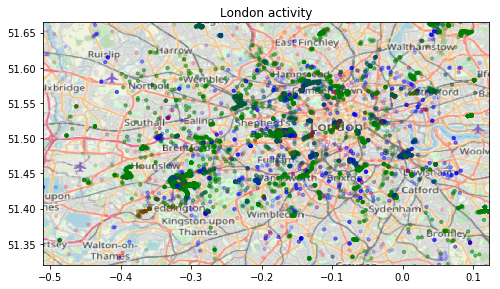

In [153]:
# drawing where users make their contributions
fig, ax = plt.subplots(figsize = (8,7))

col = np.where(london_places.type_user == 'regular','b',
               np.where(london_places.type_user == '75_perc','g','r'))

ax.scatter(london_places.longitude, london_places.latitude, zorder=1, alpha= 0.2, c=col, 
                                                  s=10)
ax.set_title('London activity')
ax.set_xlim(BBox_2018[0],BBox_2018[1])
ax.set_ylim(BBox_2018[2],BBox_2018[3])
ax.imshow(london, zorder=0, extent = BBox, aspect= 'equal')